# QSVT as a Threshold Filter

In this notebook we demonstrate how **Quantum Singular Value Transformation (QSVT)** can be used to implement *filters* on singular values.

We will apply a **polynomial approximation of a step function** that is close to:

$$
f(x) \approx 
\begin{cases}
0, & |x| < 0.5 \\
1, & |x| \ge 0.5
\end{cases}
$$

This is a *singular-value thresholding filter*.  
We use a **degree-3 polynomial** approximation for simplicity.


In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


## Toy Matrix

We define a diagonal matrix whose singular values are:

$$
\sigma = [1.0,\, 0.7,\, 0.3,\, 0.1].
$$

Our goal is to apply a QSVT polynomial that keeps the large singular
values (≥ 0.5) and suppresses the small ones (< 0.5).


In [3]:
singular_values = np.array([1.0, 0.7, 0.3, 0.1])
A = np.diag(singular_values)
print("Matrix A:\n", A)


Matrix A:
 [[1.  0.  0.  0. ]
 [0.  0.7 0.  0. ]
 [0.  0.  0.3 0. ]
 [0.  0.  0.  0.1]]


## Polynomial Filter (QSVT-Compatible)

QSVT requires that the polynomial satisfy:

$$ |f(x)| \le 1 \quad \text{for all } x \in [-1, 1]. $$

This means arbitrary step-like polynomials are *not* allowed unless they
are carefully normalised.

For a simple and QSVT-valid singular-value filter, we use:

$$ f(x) = x^2. $$

This acts as a **soft threshold filter**:

- large singular values stay near 1,
- small singular values shrink rapidly.

Even low-degree even polynomials give smooth filtering behaviour.


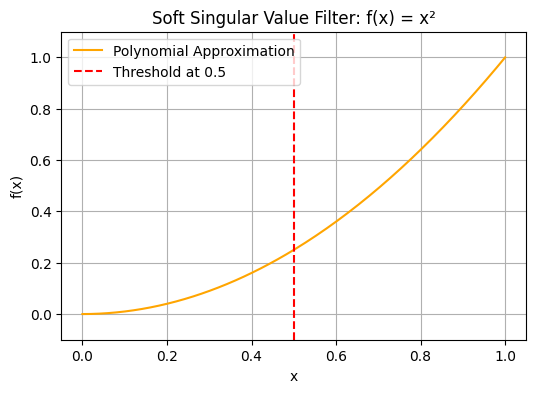

In [ ]:
def classical_filter(x):
    return x**2

filter_poly = [0, 0, 1]

x = np.linspace(0, 1, 200)
y = classical_filter(x)

plt.figure(figsize=(6,4))
plt.plot(x, y, label="Polynomial Approximation", color="orange")
plt.axvline(0.5, color="red", linestyle="--", label="Threshold at 0.5")
plt.ylim(-0.1, 1.1)
plt.title("Soft Singular Value Filter: f(x) = x²")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()


## Applying QSVT to Matrix A

We now apply:

$$ f(\sigma_i) \approx \text{threshold}(\sigma_i - 0.5). $$

PennyLane can automatically block-encode a diagonal matrix using the
`"embedding"` method. Then `qml.qsvt()` applies the polynomial
transformation to the singular values.


In [5]:
wire_order = [0, 1, 2]   # 3 wires is enough for 4 singular values

U_A = qml.matrix(qml.qsvt, wire_order=wire_order)(
    A, filter_poly, encoding_wires=wire_order, block_encoding="embedding"
)

# Extract top-left block diagonal = transformed singular values
transformed = np.real(np.diagonal(U_A))[:len(singular_values)]

transformed


array([1.  , 0.49, 0.09, 0.01])

We compare:

- original singular values σᵢ,
- transformed values f(σᵢ) = σᵢ².

This is a *soft filter*:

- 1.0   → 1.0
- 0.7   → 0.49
- 0.3   → 0.09
- 0.1   → 0.01

This is not a sharp threshold, but it is a valid QSVT polynomial and
demonstrates singular-value suppression.


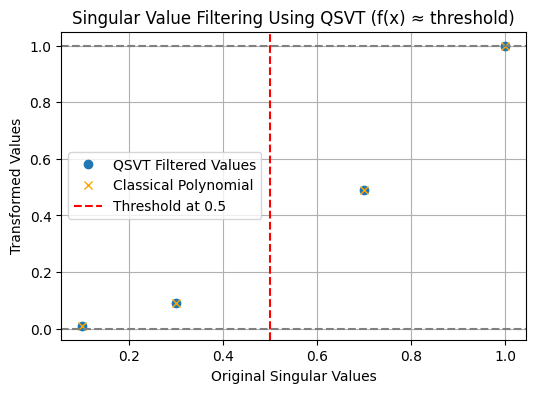

In [6]:
# Plot the results
plt.figure(figsize=(6,4))
plt.plot(singular_values, transformed, "o", label="QSVT Filtered Values")
plt.plot(singular_values, classical_filter(singular_values), "x", label="Classical Polynomial", color="orange")
plt.axhline(0.0, color="grey", linestyle="--")
plt.axhline(1.0, color="grey", linestyle="--")
plt.xlabel("Original Singular Values")
plt.ylabel("Transformed Values")
plt.axvline(0.5, color="red", linestyle="--", label="Threshold at 0.5")
plt.title("Singular Value Filtering Using QSVT (f(x) ≈ threshold)")
plt.legend()
plt.grid(True)
plt.show()
